In [1]:
# Import libraries
import numpy as np
import os
import matplotlib.pyplot as plt

from scipy.fftpack import dct
import numpy as np


In [653]:
# Define data pre-processing functions 

# Import the mnist dataset 
def import_mnist_data(num_img):
    # Unzip the mnist data
    if not os.path.exists("mnist_dataset/"):
        !unzip mnist_dataset.zip
    # Load the mnist data
    # Ignore the first column of the data (the label)
    data = np.loadtxt("mnist_dataset/mnist_test.csv", delimiter=",", max_rows=num_img, usecols=range(1,785))
    data = data.reshape(num_img, 784)
    return data

# Sparsify the data by setting all values below a threshold to 0
def sparsify_data(data, threshold):
    sparse_data = np.copy(data)
    for i in range(sparse_data.shape[0]):
        for j in range(sparse_data.shape[1]):
            if sparse_data[i,j] < threshold: 
                sparse_data[i,j] = 0

    return sparse_data

# Generates a random measurement matrix with normalized columns
def make_meas_matrix(rows, cols):
    # Generate a matrix of numbers from the standard normal distribution
    meas_matrix = np.random.randn(rows, cols)
    # Normalize the columns of the matrix
    for i in range(cols):
        meas_matrix[:,i] = meas_matrix[:,i] / np.linalg.norm(meas_matrix[:,i])

    return meas_matrix

#we can  use this too and see
def make_dct_meas_matrix(rows, cols):
    D = dct(np.eye(cols), norm='ortho')  
    return D[:rows, :]  

# Generate measurements from the data using the measurement matrix
def get_measurements(data, meas_matrix):
    return np.sign(meas_matrix @ data.T)

# Plot the original image and the estimated image
def plot_est_images(original_data, est_data):
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(original_data.reshape(28,28), cmap='gray_r', vmin=0, vmax=255)
    axs[0].set_title("Original Image")
    axs[1].imshow(est_data.reshape(28,28), cmap='gray_r', vmin=0, vmax=255)
    axs[1].set_title("Reconstructed Image")
    plt.show()

def plot_rfpi_biht(original_data, rfpi_data, biht_data):
    fig, axs = plt.subplots(1, 3)
    axs[0].imshow(original_data.reshape(28,28), cmap='gray_r', vmin=0, vmax=255)
    axs[0].set_title("Original Image")
    axs[1].imshow(rfpi_data.reshape(28,28), cmap='gray_r', vmin=0, vmax=255)
    axs[1].set_title("RFPI Reconstructed Image")
    axs[2].imshow(biht_data.reshape(28,28), cmap='gray_r', vmin=0, vmax=255)
    axs[2].set_title("BIHT Reconstructed Image")
    plt.show()

def plot_meas_matrix(meas_matrix):
    plt.imshow(meas_matrix, cmap='rainbow', vmin=-1, vmax=1)
    plt.title("Measurement Matrix")
    plt.show()

(1, 784)
(1, 784)


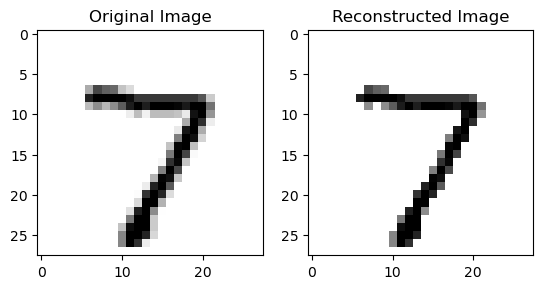

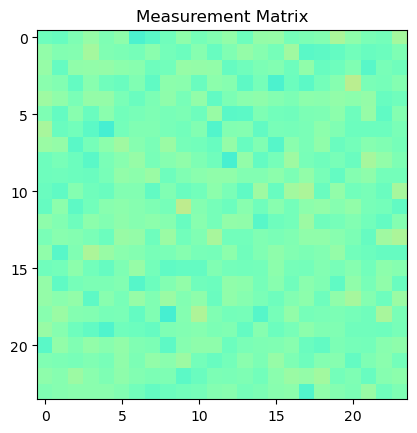

In [654]:
# Testing out data pre-processing functions

data = import_mnist_data(1)
print(data.shape)

sparse_data = sparsify_data(data, 100) #anything below 100 is = zero
print(sparse_data.shape)

plot_est_images(data, sparse_data)

meas_matrix = make_meas_matrix(200,784)
plot_meas_matrix(meas_matrix[0:24,0:24])

measurement = get_measurements(sparse_data, meas_matrix)

**Functions**

In [ ]:
def get_k_support(v, k):
    w = np.copy(v)
    support = np.empty(0, dtype=int)
    for i in range(0, k):
        max_index = np.argmax(abs(w))
        support = np.append(support, max_index)
        w[max_index] = 0
    return support

def calculate_normalized_mse(original_data, est_data):
    return np.linalg.norm(original_data - est_data)**2 / np.linalg.norm(original_data)**2

def calculate_hamming_error(measurement, meas_matrix, est_data):
    return np.count_nonzero(measurement - np.sign(meas_matrix @ est_data))/measurement.shape[0]

def soft_thresholding(x, threshold):
    return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)

# Sign-truncated matching pursuit: https://arxiv.org/pdf/1312.3418
# not working
def strmp(meas_matrix, measurement, err_threshold, max_iter):
    estimate = np.zeros((meas_matrix.shape[1], 1))
    support = np.empty(0, dtype=int)
    residual = measurement

    c0 = 10
    # Compute first index
    h0 = np.argmax(abs(meas_matrix.T @ residual))
    meas_matrix_h0 = meas_matrix[:,h0]
    meas_matrix_h0c = np.delete(meas_matrix, h0, axis=1)
    C = np.diag(measurement) @ (np.eye(meas_matrix.shape[0]) - np.outer(meas_matrix[:,h0], meas_matrix[:,h0])/np.inner(meas_matrix[:,h0], meas_matrix[:,h0])) @ meas_matrix_h0c
    d = (c0 / np.inner(meas_matrix[:,h0], meas_matrix[:,h0])) @ np.diag(measurement) @ meas_matrix_h0
    iter = 0
    while np.linalg.norm(min((C @ estimate - d), 0))^2 >= 0.1 and iter < max_iter:
        # Matching step
        h = C.T @ min((C @ estimate - d), 0)
        # Support identification step
        k = np.argmax(abs(h))
        # Augment the support vector
        support = np.append(support, k)
        support = np.sort(support)
        # Update estimate
        all_indices = np.arange(meas_matrix.shape[1])  # All column indices
        complement_support = np.setdiff1d(all_indices, support)  # Get complement of support
        estimate[complement_support, :] = 0  # Zero out complement of support
        C_mat = min((C @ estimate - d), 0)
        estimate = np.linalg.inv(C_mat.T @ C_mat) @ (C_mat.T @ measurement)
        # Update residual
        residual = measurement - meas_matrix @ estimate
        iter += 1

    return estimate

# https://link.springer.com/article/10.1007/s11704-017-6132-7?utm_source=chatgpt.com
# https://arxiv.org/pdf/2207.03427
def biht(meas_matrix, measurement, lamda, step_size, sparsity, threshold, max_iter):

    estimate = np.zeros((meas_matrix.shape[1], 1))
    convergence = []

    iter = 0
    residual = np.linalg.norm(measurement)
    while iter < max_iter and residual > threshold:
        partial_f = (lamda/2) * meas_matrix.T @ (np.sign(measurement) - np.sign(meas_matrix @ estimate))
        last_estimate = estimate
        estimate = estimate + step_size * partial_f
        
        # Hard thresholding
        support = get_k_support(estimate, sparsity)
        temp = np.zeros((meas_matrix.shape[1], 1))
        temp[support,:] = estimate[support,:]
        estimate = temp

        residual = np.linalg.norm(estimate - last_estimate)
        convergence.append(residual)

        iter += 1
    return estimate, convergence

# https://publications.lib.chalmers.se/records/fulltext/164371/local_164371.pdf
def rfpi(meas_matrix, measurement, step_size, lamda, threshold, max_iter):

    estimate = np.linalg.pinv(meas_matrix) @ measurement
    Y = np.diagflat(measurement)
    iter = 0
    convergence = []

    residual = np.linalg.norm(measurement)
    while iter < max_iter and residual > threshold:
        last_estimate = estimate
        s = (Y @ meas_matrix).T @ np.maximum(np.multiply(measurement, meas_matrix @ estimate), np.zeros_like(measurement))
        g = s - (s.T @ estimate) * estimate 
        h = estimate - step_size * g
        estimate = soft_thresholding(h, step_size/lamda)
        estimate /= np.linalg.norm(estimate)
        iter += 1

        residual = np.linalg.norm(estimate - last_estimate)
        convergence.append(residual)
    return estimate, convergence
    


In [679]:
# Loop to test algorithms on multiple images
def test_algo(algo, num_images, sparse_data, measurement_dims, step_size, lamda, sparsity, threshold, max_iter):

    mses = []
    hamming_errors = [] 

    for m in measurement_dims:
        mse_dim = []
        hamming_error_dim = []
        for idx in range(0,num_images):
            curr_data = sparse_data[idx,:]
            meas_matrix = make_meas_matrix(m,784)
            measurement = np.reshape(get_measurements(curr_data, meas_matrix), (m,1))
            
            if (algo == "rfpi"):
                estimate, convergence = rfpi(meas_matrix, measurement, step_size, lamda, threshold, max_iter)
            elif (algo == "biht"):
                estimate, convergence = biht(meas_matrix, measurement, lamda, step_size, sparsity, threshold, max_iter)
            
            # Renormalize for plotting
            estimate = abs(estimate) * 255/(np.max(abs(estimate)))
            hamming_error = calculate_hamming_error(measurement, meas_matrix, estimate)
            hamming_error_dim.append(hamming_error)
            mse = calculate_normalized_mse(curr_data, estimate)
            mse_dim.append(mse)


        mses.append(np.mean(mse_dim))
        hamming_errors.append(np.mean(hamming_error_dim))

    return mses, hamming_errors, curr_data, estimate, convergence

In [ ]:
meas_matrix_dims = [25,50,100,200,300,400,500,600,700]
num_img = 20
data = import_mnist_data(num_img)
sparse_data = sparsify_data(data, 100)

mses_rfpi, hamming_errors_rfpi, curr_data, estimate_rfpi, convergence_rfpi = test_algo("rfpi", num_img, sparse_data, meas_matrix_dims, 1e-6, 0.02, 0, 1e-3, 1000)
mses_biht, hamming_errors_biht, curr_data, estimate_biht, convergence_biht = test_algo("biht", num_img, sparse_data, meas_matrix_dims, 1e-5, 0.1, 80, 1e-3, 1000)

plot_rfpi_biht(curr_data, estimate_rfpi, estimate_biht)

fig, axs = plt.subplots(1, 2)
fig.set_figwidth(16)
axs[0].plot(meas_matrix_dims, mses_rfpi)
axs[0].plot(meas_matrix_dims, mses_biht)
axs[0].set_title("MSE")
axs[0].set_xlabel("Number of columns in measurement matrix")
axs[0].set_ylabel("MSE")
axs[0].legend(["RFPI", "BIHT"])
axs[1].plot(meas_matrix_dims, hamming_errors_rfpi)
axs[1].plot(meas_matrix_dims, hamming_errors_biht)
axs[1].set_title("Hamming Error")
axs[1].set_xlabel("Number of columns in measurement matrix")
axs[1].set_ylabel("Hamming error")
axs[1].legend(["RFPI", "BIHT"])
plt.show()

# plt.figure(figsize=(6, 4))
# plt.semilogy(convergence)
# plt.xlabel("Iteration")
# plt.ylabel("Change in estimate")
# plt.title("Convergence")
# plt.grid(True)
# plt.tight_layout()
# plt.show()


RFPI Iterations:  1000
RFPI Iterations:  1000
RFPI Iterations:  1000
RFPI Iterations:  1000
RFPI Iterations:  1000
RFPI Iterations:  1000
RFPI Iterations:  1000
RFPI Iterations:  1000
RFPI Iterations:  1000
RFPI Iterations:  1000
RFPI Iterations:  1000
RFPI Iterations:  1000
RFPI Iterations:  1000
RFPI Iterations:  968
RFPI Iterations:  1000
RFPI Iterations:  1000
RFPI Iterations:  1000
RFPI Iterations:  1000
RFPI Iterations:  1000
RFPI Iterations:  1000
RFPI Iterations:  1000
RFPI Iterations:  1000
RFPI Iterations:  1000
RFPI Iterations:  1000
RFPI Iterations:  1000
RFPI Iterations:  1000
RFPI Iterations:  1000
RFPI Iterations:  1000
RFPI Iterations:  1000
RFPI Iterations:  1000
RFPI Iterations:  1000
RFPI Iterations:  1000
RFPI Iterations:  1000
RFPI Iterations:  1000
RFPI Iterations:  1000
RFPI Iterations:  1000
RFPI Iterations:  1000
RFPI Iterations:  1000
RFPI Iterations:  1000
RFPI Iterations:  1000
RFPI Iterations:  1000
RFPI Iterations:  1000
RFPI Iterations:  1000
RFPI Iterati

KeyboardInterrupt: 

Iterative Shrinkage threshoding algorithm

In [132]:
def soft_thresholding(x, threshold):
    return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)

def ista(meas_matrix, measurement, eta, threshold, max_iter):
    estimate = np.zeros((meas_matrix.shape[1], 1))
    convergence = []
    for t in range(max_iter):
        update = estimate - 2 * eta * meas_matrix.T @ (meas_matrix @ estimate - measurement)
        estimate = soft_thresholding(update, threshold)
        diff = np.linalg.norm(update - estimate)
        convergence.append(diff)
        #print(f"Iter {t}: Update norm = {diff:.6f}")

    return estimate, convergence



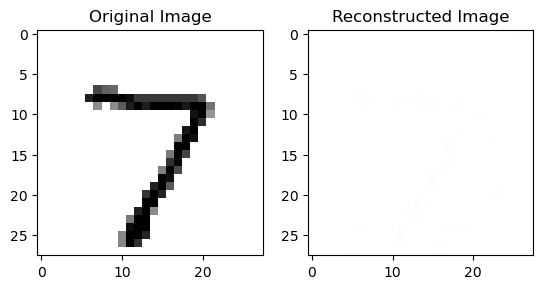

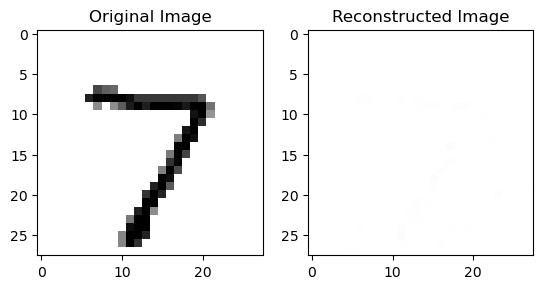

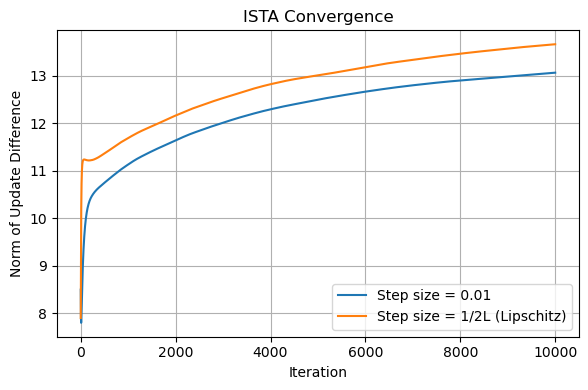

In [111]:
meas_matrix = make_meas_matrix(300,784)
measurement = get_measurements(sparse_data, meas_matrix)

eta = 0.01
estimate, convergence = ista(meas_matrix, measurement, eta, 0.001, 10000)
#estimate = sparsify_data(abs(estimate), 100)
plot_est_images(sparse_data, estimate)

L = np.linalg.norm(meas_matrix.T @ meas_matrix, 2)  # Lipschitz constant
eta = 1 / (2 * L)  
estimate, convergence_lipschitz = ista(meas_matrix, measurement, eta, 0.001, 10000)
#estimate = sparsify_data(abs(estimate), 100)
plot_est_images(sparse_data, estimate)

# Plot convergence 
plt.figure(figsize=(6, 4))
plt.plot(convergence)
plt.plot(convergence_lipschitz)
plt.xlabel("Iteration")
plt.ylabel("Norm of Update Difference")
plt.title("ISTA Convergence")
plt.legend(["Step size = 0.01", "Step size = 1/2L (Lipschitz)"])
plt.grid(True)
plt.tight_layout()
plt.show()